In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from pathlib import Path
from datasets import Dataset, load_dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoFeatureExtractor, TrOCRProcessor, VisionEncoderDecoderModel, DefaultDataCollator
import requests
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, ToPILImage
from matplotlib import pyplot as plt
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
import random
#import cv2



In [512]:
csv_input = pd.read_csv('..\privateDir\labels\labels.csv', sep = ';')
csv_input

,ID,Label
0,1,male
1,2,female
2,3,male
3,4,female
4,8,male
5,10,female


In [513]:
#images_labels = dict(csv_input)
images_labels= pd.Series(csv_input.Label.values,index=csv_input.ID).to_dict()
images_labels

{1: 'male', 2: 'female', 3: 'male', 4: 'female', 8: 'male', 10: 'female'}

In [514]:
"""Create Dataset: Load images"""
IMAGES = '..\privateDir\example_images\segmented'
images_path = Path(IMAGES)


In [515]:
all_images = []
for idx, label in images_labels.items():
    for img_path in (images_path / f'{idx:03}').glob('*.jpeg'):
        all_images.append({ 'label': label, 'path': img_path })

print(all_images)

[{'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/001/001.jpeg')}, {'label': 'female', 'path': WindowsPath('../privateDir/example_images/segmented/002/002.jpeg')}, {'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/003/003.jpeg')}, {'label': 'female', 'path': WindowsPath('../privateDir/example_images/segmented/004/004.jpeg')}, {'label': 'male', 'path': WindowsPath('../privateDir/example_images/segmented/008/008.jpeg')}, {'label': 'female', 'path': WindowsPath('../privateDir/example_images/segmented/010/010.jpeg')}]


In [516]:
"""Create Dataset: Define IDs for target labels"""
labels = ['male', 'female']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label]      = i
    id2label[i]     = label

print(label2id, id2label)

{'male': 0, 'female': 1} {0: 'male', 1: 'female'}


In [517]:
def _generator():
    for l in all_images:
        yield {'label': label2id[l['label']], 
               #'image': np.array(Image.open(l['path']).getdata()).reshape(Image.open(l['path']).size[0], Image.open(l['path']).size[1], 3)}
                'image': Image.open(l['path'])}
        
#pic = Image.open("foo.jpg")
#pix = numpy.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)



In [518]:
ds=Dataset.from_generator(_generator)
ds = ds.train_test_split(test_size=0.2)
#ds['train']['image']
ds

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 4
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 2
    })
})

In [519]:
ds['train'][0]
#img = x_train[0].resize((300, 300), Image.Resampling.LANCZOS)
#img

{'label': 0,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2480x3507>}

In [520]:
#np.asarray(x_train[0])

In [233]:
#'image': np.array(Image.open(l['path']).getdata()).reshape(Image.open(l['path']).size[0], Image.open(l['path']).size[1], 3)}

In [234]:
#def convert(pil_image)-> np.array:
#    # converts PIL image into one-dimensional, reshaped array
#    r = np.asarray(pil_image)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0


In [257]:
#def convert(pil_image)-> np.array:
    # converts PIL image into one-dimensional, reshaped array
#    base_width= 300
#    img = pil_image
    #wpercent = (base_width / float(img.size[0]))
    #hsize = int((float(img.size[1]) * float(wpercent)))
#    hsize = 300
#    img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
#    r = np.asarray(img)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0

In [ ]:
#def convert(pil_image)-> np.array:
#    # converts PIL image into one-dimensional, reshaped array
#    base_width= 300
#    img = pil_image
    #wpercent = (base_width / float(img.size[0]))
    #hsize = int((float(img.size[1]) * float(wpercent)))
#    hsize = 300
#    img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
#    r = np.asarray(img)
#    nx, ny, nrgb = r.shape
#    s = r.reshape(nx*ny*nrgb)
#    return s/255.0

In [521]:
def convert(pil_image)-> np.array:
    # converts PIL image into one-dimensional, reshaped array
    r = np.asarray(pil_image)
    nx, ny, nrgb = r.shape
    s = r.reshape(nx*ny*nrgb)
    s = s/255.0
    return list(s)

In [522]:
CHECKPOINT="google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

In [523]:
def tensor_to_image(t) -> Image:
    transform=ToPILImage()
    return transform(t)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
# in other processors, maybe use 'shortest_edge'
size = (processor.size["height"], processor.size["width"] )
# JV suggests: do not normalize bc these are no food images
#_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
#_transforms = Compose([Resize(size), ToTensor(), normalize])
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

print(size)
def transforms(examples):
    """Transform the image in the Dataset row."""
    examples["pixel_values"] = np.asarray([convert(tensor_to_image(_transforms(img.convert("RGB")))) for img in examples["image"]])
    examples["label"]= np.asarray([[label] for label in examples['label']]).astype('uint8')
    #print(examples, "\n")
    del examples["image"]
    return examples

ds2 = ds.with_transform(transforms)
#tensor = ds2['train'][0]['pixel_values']

#img = tensor_to_image(tensor)
img = ds2['train'][:]['pixel_values']
#img.shape
#plt.imshow(img)
#plt.show()


(224, 224)


In [524]:
ds2['train'][:]['pixel_values']

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.9372549 , 0.9372549 , 0.9372549 , ..., 0.90588235, 0.90588235,
        0.90588235]])

In [351]:
#images = [tensor_to_image(yxi) for yxi in ds2['train'][:]['pixel_values']]
#images

[<PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>]

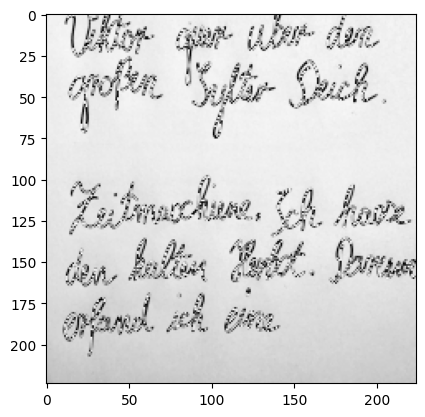

In [356]:
#images = [tensor_to_image(yxi) for yxi in ds2['train'][:]['pixel_values']]
#plt.imshow(images[0], cmap='gray')
#plt.show()

In [345]:
#ds2['train'][:]['pixel_values'] = [tensor_to_image(xi) for xi in ds2['train'][:]['pixel_values']]

In [363]:
#for xi in ds2['train'][:]['pixel_values']:
#    ds2['train'][:]['images'] = tensor_to_image(xi)

In [369]:
#ds2['train'][:]['images']

KeyError: 'images'

In [350]:
#ds2['train'][:]['pixel_values']

[tensor([[[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ..., 0.9608, 0.9451, 0.9451],
          ...,
          [0.8824, 0.8824, 0.8824,  ..., 0.9216, 0.9137, 0.9216],
          [0.8745, 0.8824, 0.8824,  ..., 0.9216, 0.9216, 0.9216],
          [0.8667, 0.8824, 0.8824,  ..., 0.9137, 0.9294, 0.9216]],
 
         [[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ..., 0.9608, 0.9451, 0.9451],
          ...,
          [0.8824, 0.8824, 0.8824,  ..., 0.9216, 0.9137, 0.9216],
          [0.8745, 0.8824, 0.8824,  ..., 0.9216, 0.9216, 0.9216],
          [0.8667, 0.8824, 0.8824,  ..., 0.9137, 0.9294, 0.9216]],
 
         [[0.9216, 0.9137, 0.9294,  ..., 0.9608, 0.9529, 0.9529],
          [0.9137, 0.9216, 0.9137,  ..., 0.9529, 0.9451, 0.9608],
          [0.9216, 0.9137, 0.9137,  ...,

In [526]:
ds2['train'][:]['label']

array([[0],
       [0],
       [1],
       [1]], dtype=uint8)

In [525]:
#(x_train, y_train), (x_test, y_test) = (ds['train']['image'], ds['train']['label']),(ds['test']['image'], ds['test']['label'])
(x_train, y_train), (x_test, y_test) = (ds2['train'][:]['pixel_values'], ds2['train'][:]['label']),(ds2['test'][:]['pixel_values'], ds2['test'][:]['label'])

In [527]:
y_train

array([[0],
       [0],
       [1],
       [1]], dtype=uint8)

In [528]:
y_test

array([[0],
       [1]], dtype=uint8)

In [258]:
#x_train2= [convert(xi) for xi in x_train]

In [529]:
x_train

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.92941176, 0.92941176, 0.92941176, ..., 0.84313725, 0.84313725,
        0.84313725]])

In [530]:
x_train.shape, x_test.shape

((4, 150528), (2, 150528))

In [ ]:
#x_train = x_train/255.0
#x_test = x_test/255.0

In [ ]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to
#2d array
#nsamples, nx, ny, nrgb = x_train.shape
#x_train2 = x_train.reshape((nsamples,nx*ny*nrgb))

In [ ]:
##so,eventually,model.predict() should also be a 2d input
#nsamples, nx, ny, nrgb = x_test.shape
#x_test2 = x_test.reshape((nsamples,nx*ny*nrgb))

In [531]:
x_train

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.92941176, 0.92941176, 0.92941176, ..., 0.84313725, 0.84313725,
        0.84313725]])

In [532]:
y_train

array([[0],
       [0],
       [1],
       [1]], dtype=uint8)

In [533]:
model=RandomForestClassifier()

In [534]:
model.fit(x_train,y_train)

c:\Users\Dr. Emilia Boehm\DataScienceCourseSpiced\Capstone\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [535]:
y_pred=model.predict(x_test)
y_pred

array([0, 1], dtype=uint8)

In [536]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [268]:
confusion_matrix(y_pred,y_test)

array([[0, 1],
       [0, 0]], dtype=int64)